<a href="https://colab.research.google.com/github/luegl/keras_cat_vs_dog_model/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/gdrive


In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   125M      0  0:00:06  0:00:06 --:--:--  142M
 CDLA-Permissive-2.0.pdf   gdrive		        PetImages	 sample_data
 drive			   kagglecatsanddogs_5340.zip  'readme[1].txt'


Import Data


In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

Import

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1

            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


Filter out corrupted images

In [ ]:
image_size = (120, 120)
batch_size = 256

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


Generate Dataset

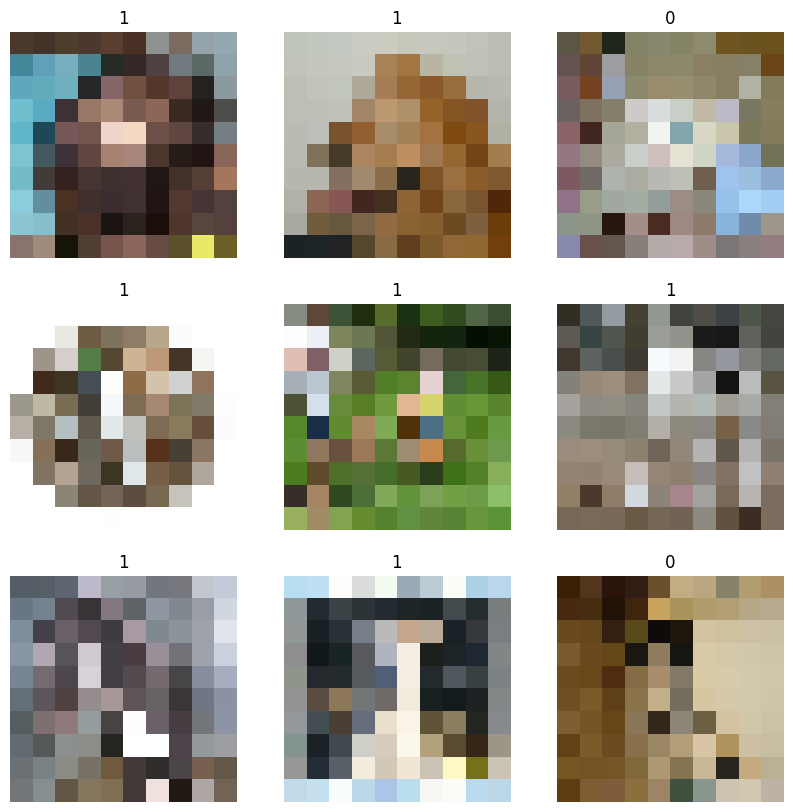

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Visualize the data

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Data augmentation

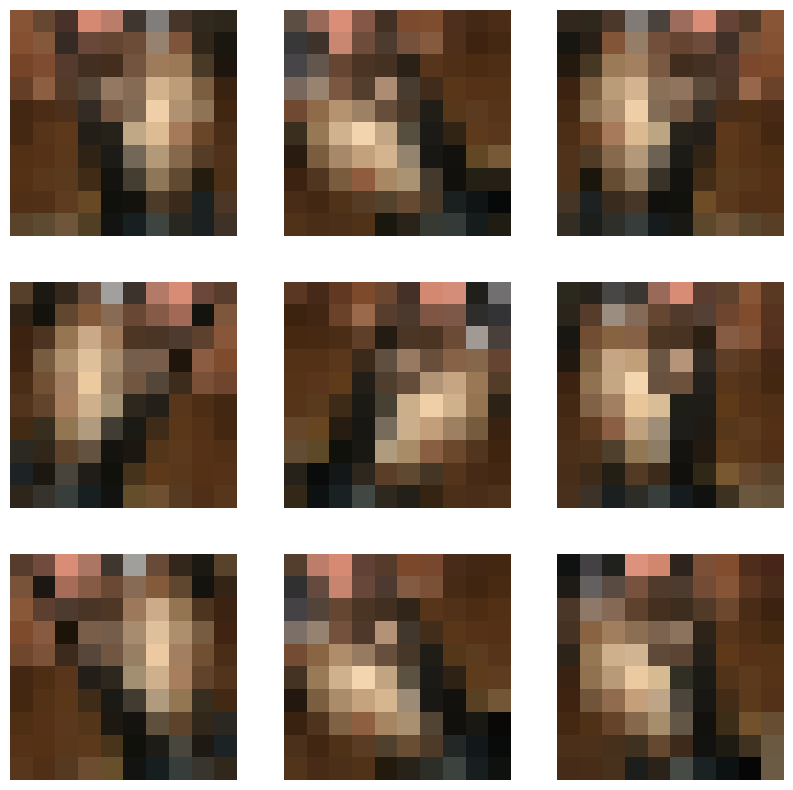

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

Visualize the augmented data

In [ ]:
"""
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

"""

'\naugmented_train_ds = train_ds.map(\n    lambda x, y: (data_augmentation(x, training=True), y))\n\n'

Preprocess the data


In [ ]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

Configure the dataset for performance


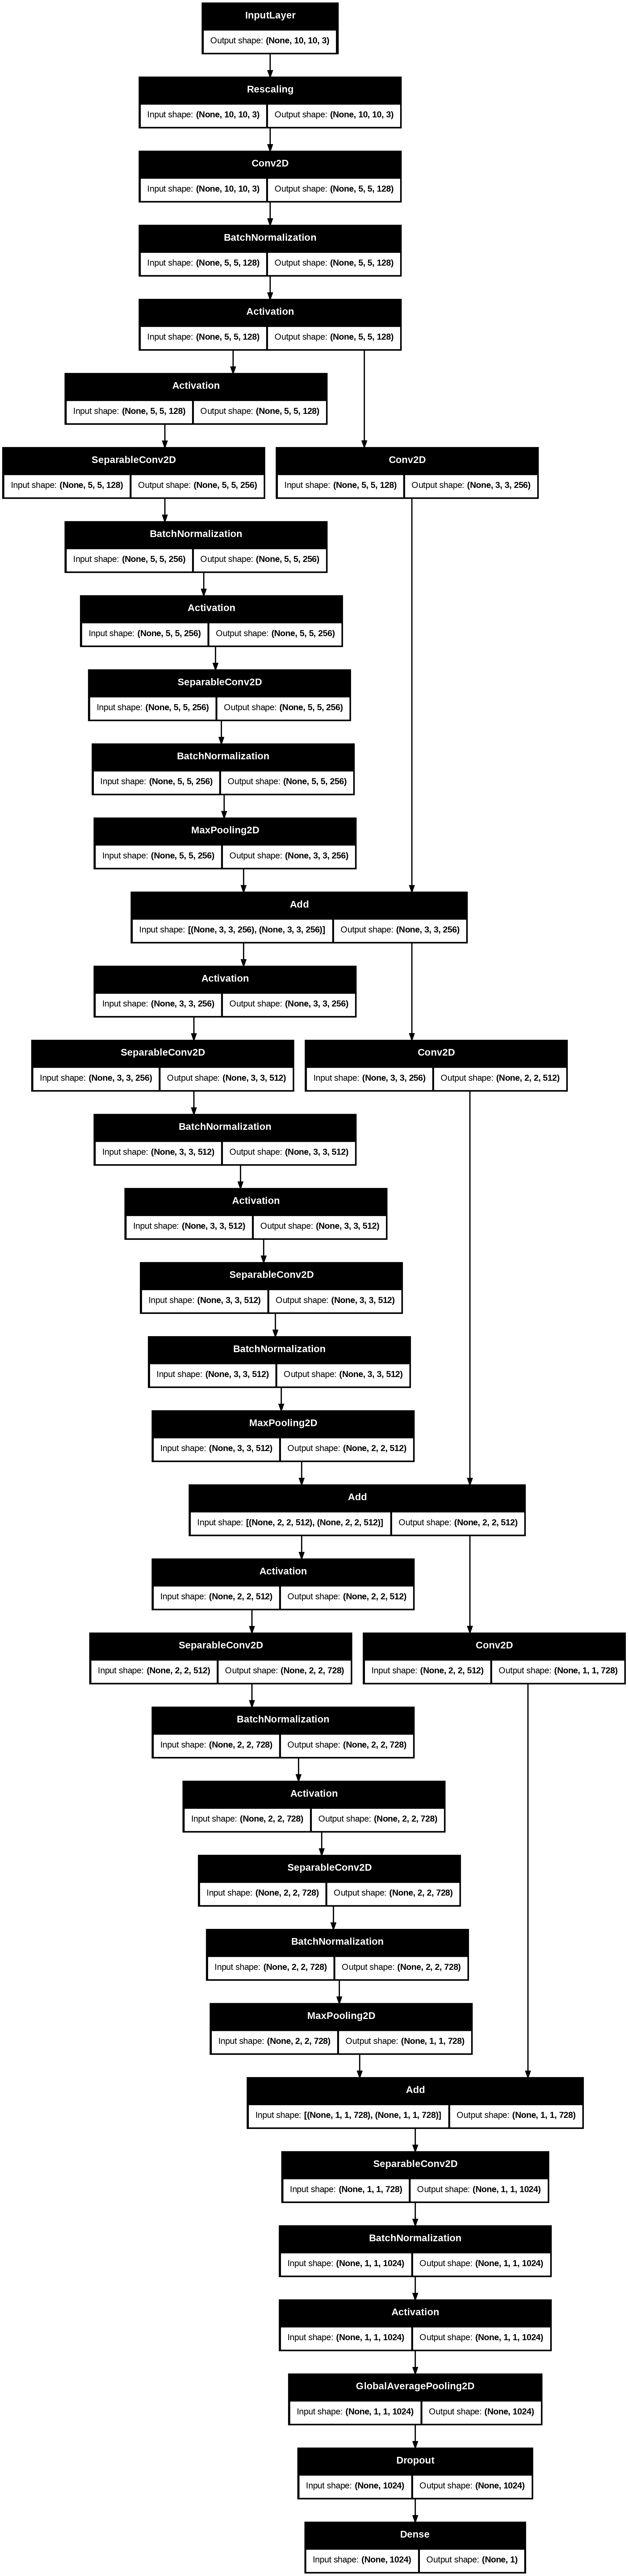

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)


    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)

    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

Build a model

In [ ]:
epochs = 25

checkpoint_path = "/content/drive/MyDrive/CatDog_Models/save_at_{epoch}.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path)
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)
model.save('catdogmodel.keras')

Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - acc: 0.5682 - loss: 0.6681 - val_acc: 0.4957 - val_loss: 0.6931
Epoch 2/25
15/74 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.6319 - loss: 0.6311

KeyboardInterrupt: 

Train model


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


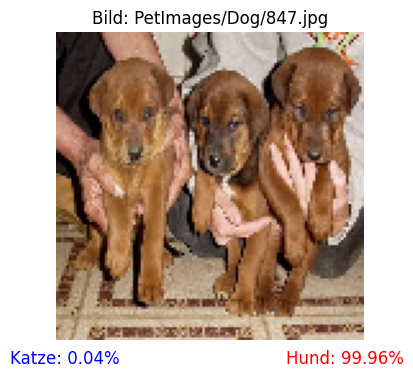

PetImages/Dog/847.jpg: 0.04% Katze, 99.96% Hund.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


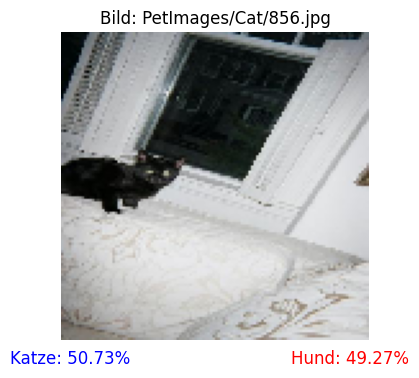

PetImages/Cat/856.jpg: 50.73% Katze, 49.27% Hund.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


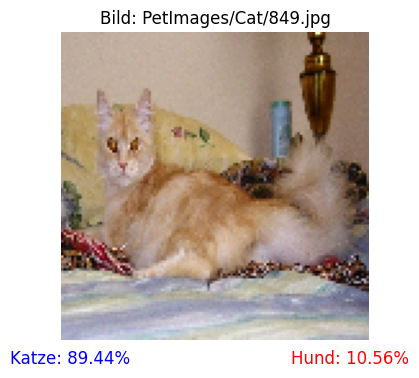

PetImages/Cat/849.jpg: 89.44% Katze, 10.56% Hund.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


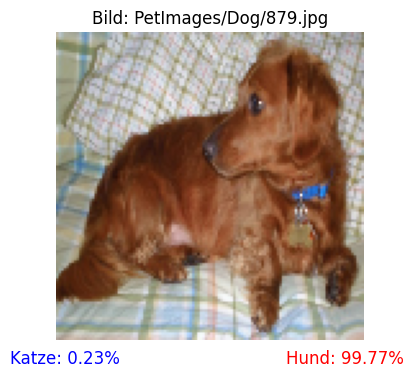

PetImages/Dog/879.jpg: 0.23% Katze, 99.77% Hund.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


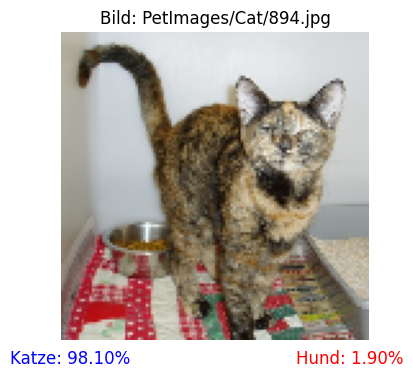

PetImages/Cat/894.jpg: 98.10% Katze, 1.90% Hund.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


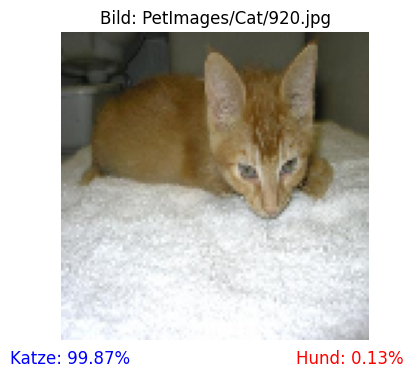

PetImages/Cat/920.jpg: 99.87% Katze, 0.13% Hund.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


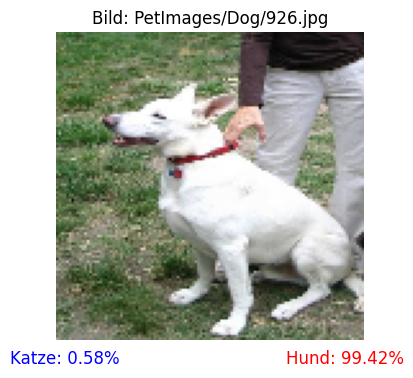

PetImages/Dog/926.jpg: 0.58% Katze, 99.42% Hund.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


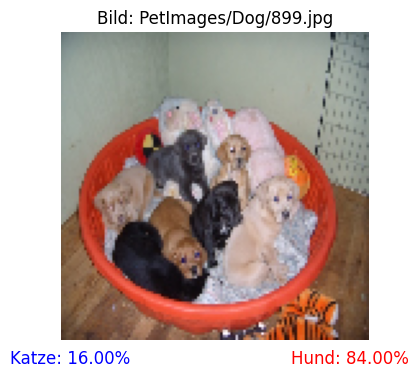

PetImages/Dog/899.jpg: 16.00% Katze, 84.00% Hund.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


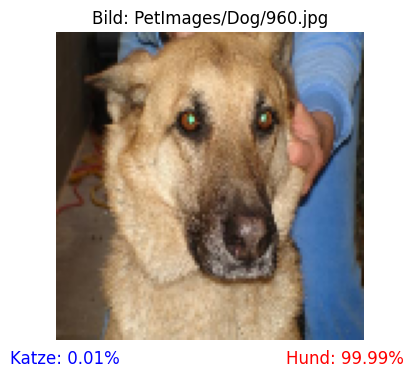

PetImages/Dog/960.jpg: 0.01% Katze, 99.99% Hund.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


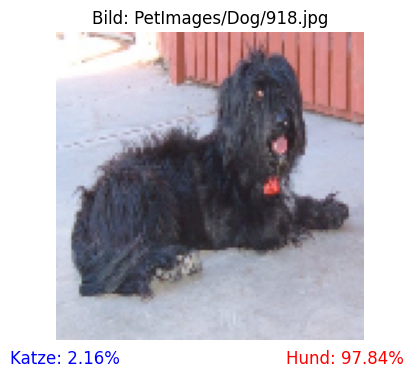

PetImages/Dog/918.jpg: 2.16% Katze, 97.84% Hund.


In [ ]:
import os
import numpy as np
import random
import keras
from keras import layers
import matplotlib.pyplot as plt

image_size = (120, 120)
model = keras.models.load_model('/content/drive/MyDrive/CatDog_Models/save_at_25.keras')


def predict_random_image():
    for _ in range(10):

        folder = random.choice(["Cat", "Dog"])

        file_number = random.randint(801, 1000)
        file_path = f"PetImages/{folder}/{file_number}.jpg"

        if not os.path.exists(file_path):
            print(f"Picture {file_path} not found, skip...")
            continue


        img = keras.utils.load_img(file_path, target_size=image_size)
        img_array = keras.utils.img_to_array(img)
        img_array = keras.ops.expand_dims(img_array, 0)


        predictions = model.predict(img_array)
        score = float(keras.ops.sigmoid(predictions[0][0]))
        cat_percentage = 100 * (1 - score)
        dog_percentage = 100 * score

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Bild: {file_path}")
        plt.figtext(0.15, 0.05, f"Katze: {cat_percentage:.2f}%", color="blue", fontsize=12, ha="center")
        plt.figtext(0.85, 0.05, f"Hund: {dog_percentage:.2f}%", color="red", fontsize=12, ha="center")

        plt.show()


        print(f"{file_path}: {cat_percentage:.2f}% Katze, {dog_percentage:.2f}% Hund.")

predict_random_image()